### 分析
- 数据特征:
    - MSSubClass: 房源类型（楼层、新旧等）
    - MSZoning: 地区分类（农业、商业等）
    - LotFrontage：地段正面
    - LotArea: 地段区域
    - Street: 街道
    - Alley: 房屋之间或后面的小巷
    - LotShape：房屋形状
    - LandCountour: 地面平整度
    - Utilities：公共设施
    - LotConfig：房面周围相邻房屋情况
    - LandSlope: 房屋地面坡度
    - 

- reference:
    - https://www.jianshu.com/p/4ad61a3eb1f3

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn import ensemble, tree, linear_model
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

E:\conda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
E:\conda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
data_train = pd.read_csv('./train.csv')
data_test = pd.read_csv('./test.csv')
print('训练集样本大小{0},测试集样本大小{1}'.format(data_train.shape, data_test.shape))


训练集样本大小(1460, 81),测试集样本大小(1459, 80)


In [4]:
#explore the dataset
sns.set(style="whitegrid",color_codes=True)
sns.set(font_scale=1)

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
data_train.describe()
data_train.get_dtype_counts()
#coreelation in data
corr=data_train.corr()["SalePrice"]
print("_______________________________________________")
print(corr[np.argsort(corr, axis=0)[::-1]]) 

_______________________________________________
SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   

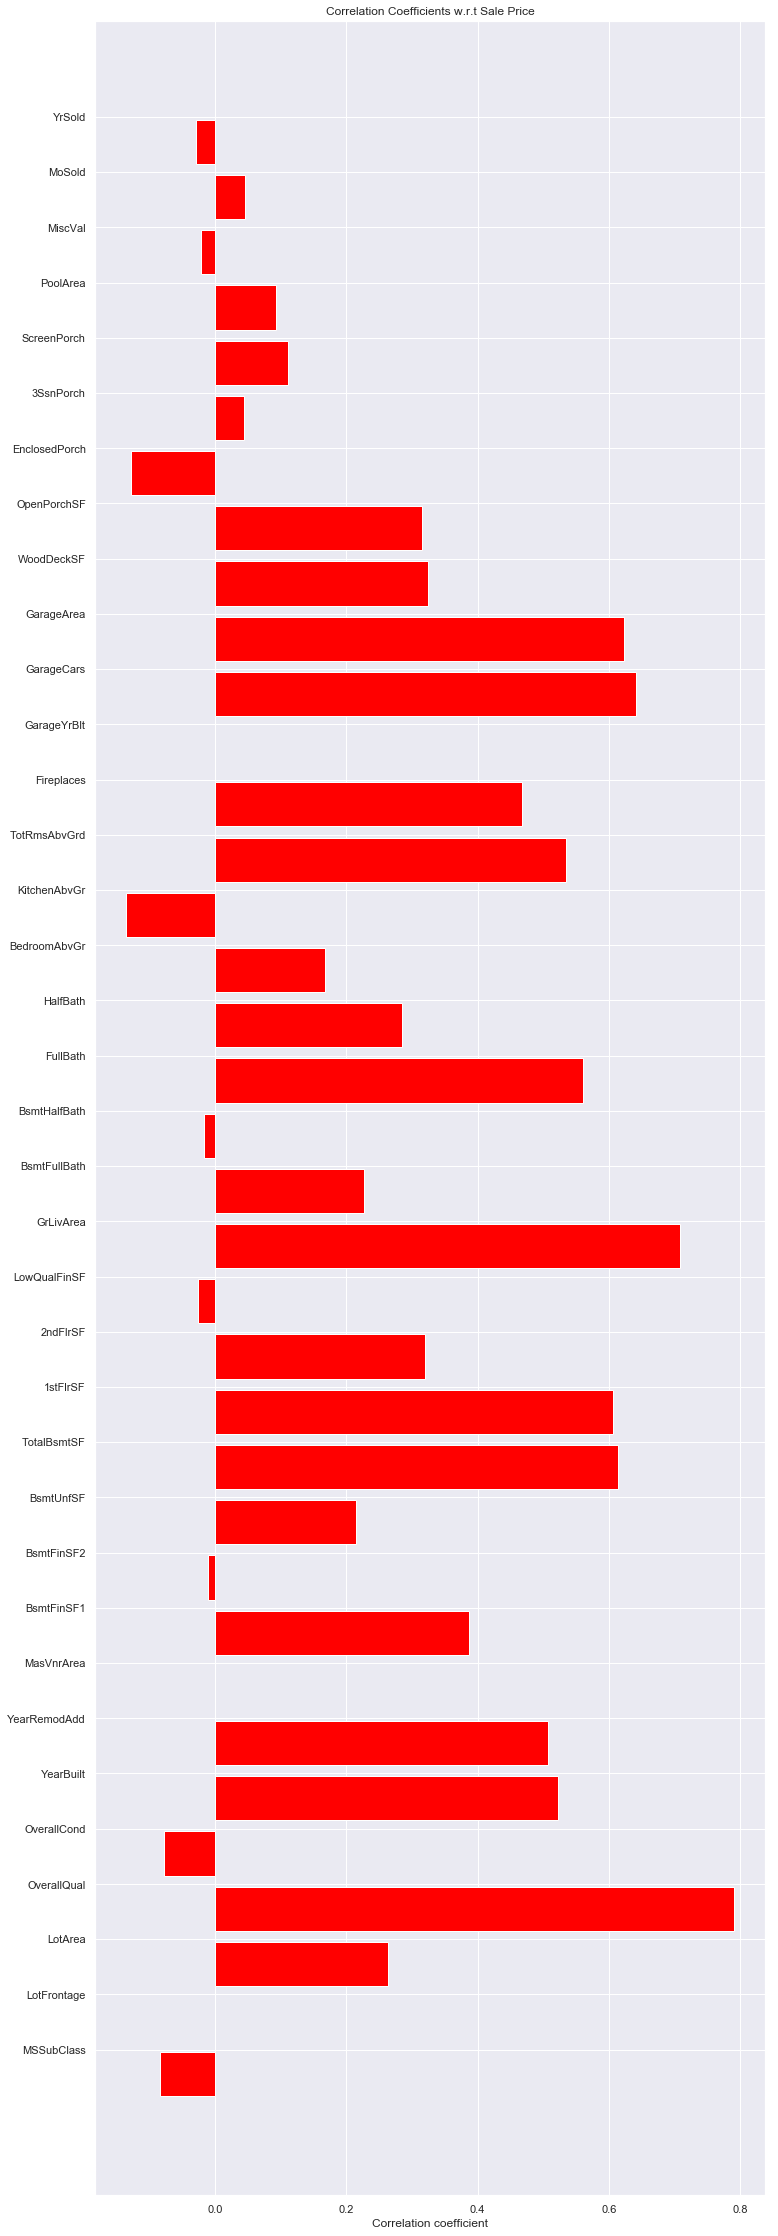

In [7]:
# plotting correlations
num_feat = data_train.columns[data_train.dtypes != object]
num_feat = num_feat[1:-1]
labels = []
values = []
for col in num_feat:
    labels.append(col)
    values.append(np.corrcoef(data_train[col].values, data_train.SalePrice.values)[0, 1])

ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12, 40))
rects = ax.barh(ind, np.array(values), color='red')
ax.set_yticks(ind + ((width) / 2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation Coefficients w.r.t Sale Price");

plt.show()

In [8]:
correlations=data_train.corr()
attrs = correlations.iloc[:-1,:-1] # all except target

threshold = 0.5  ##
important_corrs = (attrs[abs(attrs) > threshold][attrs != 1.0]) \
    .unstack().dropna().to_dict()

unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])),
        columns=['Attribute Pair', 'Correlation'])

    # sorted by absolute value
unique_important_corrs = unique_important_corrs.ix[
    abs(unique_important_corrs['Correlation']).argsort()[::-1]]

E:\conda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


In [9]:
unique_important_corrs

,Attribute Pair,Correlation
22,"(GarageArea, GarageCars)",0.882475
8,"(GarageYrBlt, YearBuilt)",0.825667
7,"(GrLivArea, TotRmsAbvGrd)",0.825489
12,"(1stFlrSF, TotalBsmtSF)",0.819530
25,"(2ndFlrSF, GrLivArea)",0.687501
6,"(BedroomAbvGr, TotRmsAbvGrd)",0.676620
19,"(BsmtFinSF1, BsmtFullBath)",0.649212
23,"(GarageYrBlt, YearRemodAdd)",0.642277
3,"(FullBath, GrLivArea)",0.630012
2,"(2ndFlrSF, TotRmsAbvGrd)",0.616423


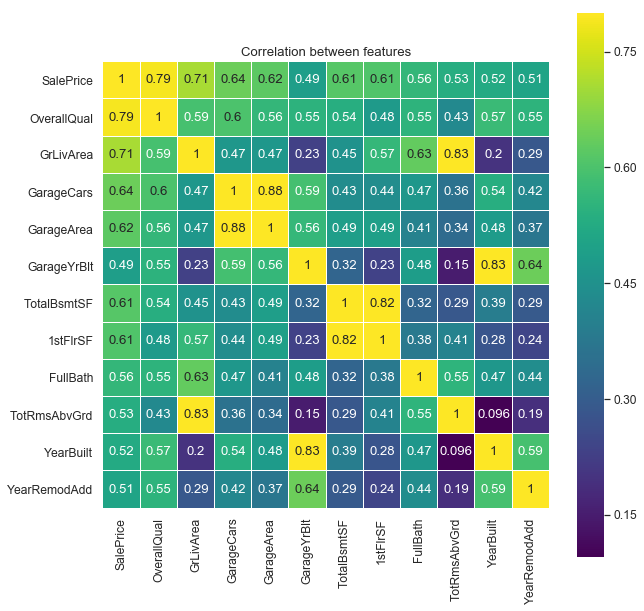

In [10]:
corrMatrix = data_train[["SalePrice", "OverallQual", "GrLivArea", "GarageCars",
                     "GarageArea", "GarageYrBlt", "TotalBsmtSF", "1stFlrSF", "FullBath",
                     "TotRmsAbvGrd", "YearBuilt", "YearRemodAdd"]].corr()
sns.set(font_scale=1.10)
plt.figure(figsize=(10,10))
sns.heatmap(corrMatrix,vmax=.8,linewidths=0.01, square=True,annot=True,cmap='viridis',linecolor="white")
plt.title('Correlation between features')
plt.show()


In [11]:
# Prints R2 and RMSE scores
def get_score(prediction, lables):
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

# Shows scores for train and validation sets
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)
    
# checking for missing data
NAs=pd.concat([data_train.isnull().sum(),data_test.isnull().sum()],axis=1,keys=['Train','Test'])
print(NAs[NAs.sum(axis=1)>0])

              Train    Test
Alley          1369  1352.0
BsmtCond         37    45.0
BsmtExposure     38    44.0
BsmtFinSF1        0     1.0
BsmtFinSF2        0     1.0
BsmtFinType1     37    42.0
BsmtFinType2     38    42.0
BsmtFullBath      0     2.0
BsmtHalfBath      0     2.0
BsmtQual         37    44.0
BsmtUnfSF         0     1.0
Electrical        1     0.0
Exterior1st       0     1.0
Exterior2nd       0     1.0
Fence          1179  1169.0
FireplaceQu     690   730.0
Functional        0     2.0
GarageArea        0     1.0
GarageCars        0     1.0
GarageCond       81    78.0
GarageFinish     81    78.0
GarageQual       81    78.0
GarageType       81    76.0
GarageYrBlt      81    78.0
KitchenQual       0     1.0
LotFrontage     259   227.0
MSZoning          0     4.0
MasVnrArea        8    15.0
MasVnrType        8    16.0
MiscFeature    1406  1408.0
PoolQC         1453  1456.0
SaleType          0     1.0
TotalBsmtSF       0     1.0
Utilities         0     2.0


E:\conda\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [12]:
#spliting to features and lables and deleting variable I don't need
train_labels=data_train.pop('SalePrice')
features=pd.concat([data_train,data_test],keys=['train','test'])
#get rid of features that have more than half of missing information or do not correlate to SalePrice
features.drop(
    ['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
     'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
     'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature',
     'MiscVal'],
    axis=1, inplace=True)

In [37]:
# LotFrontage  NA in all. I suppose NA means 0
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

# LotFrontage  NA in all. I suppose NA means 0
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

# Alley  NA in all. NA means no access
features['Alley'] = features['Alley'].fillna('NOACCESS')

# Converting OverallCond to str
features.OverallCond = features.OverallCond.astype(str)

# MasVnrType NA in all. filling with most popular values
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
# NA in all. NA means No basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('NoBSMT')
    
# TotalBsmtSF  NA in pred. I suppose NA means 0
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

# Electrical NA in pred. filling with most popular values
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

# KitchenAbvGr to categorical
features['KitchenAbvGr'] = features['KitchenAbvGr'].astype(str)

# KitchenQual NA in pred. filling with most popular values
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

# FireplaceQu  NA in all. NA means No Fireplace
features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')

# GarageType, GarageFinish, GarageQual  NA in all. NA means No Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual'):
    features[col] = features[col].fillna('NoGRG')

# GarageCars  NA in pred. I suppose NA means 0
features['GarageCars'] = features['GarageCars'].fillna(0.0)

# SaleType NA in pred. filling with most popular values
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# Year and Month to categorical
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

# Adding total sqfootage feature and removing Basement, 1st and 2nd floor features
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)


E:\conda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


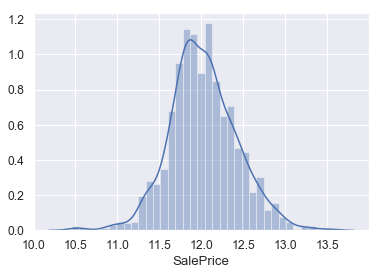

In [38]:
#Log transformation  显示价格区间分布
train_labels=np.log(train_labels)
sns.distplot(train_labels)


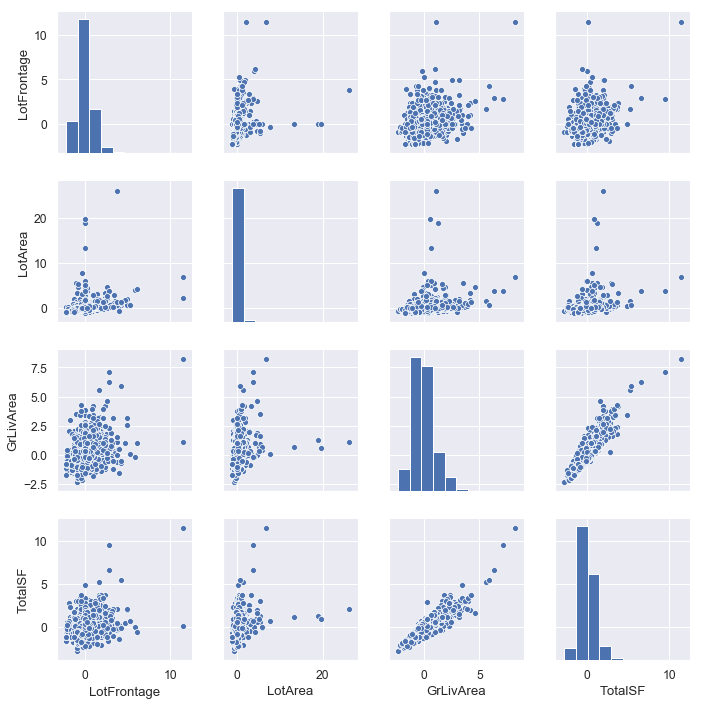

In [39]:
# Standardizing numeric data
numeric_features = features.loc[:,['LotFrontage', 'LotArea', 'GrLivArea', 'TotalSF']]
numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()
ax = sns.pairplot(numeric_features_standardized)


In [72]:

#Converting categorical data to dummies
# Getting Dummies from Condition1 and Condition2
conditions = set([x for x in features['Condition1']] + [x for x in features['Condition2']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(conditions))),
                       index=features.index, columns=conditions)
for i, cond in enumerate(list(zip(features['Condition1'], features['Condition2']))):
    dummies.ix[i, cond] = 1
features = pd.concat([features, dummies.add_prefix('Condition_')], axis=1)
features.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

E:\conda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [75]:
# Getting Dummies from Exterior1st and Exterior2nd
exteriors = set([x for x in features['Exterior1st']] + [x for x in features['Exterior2nd']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(exteriors))),
                       index=features.index, columns=exteriors)
for i, ext in enumerate(list(zip(features['Exterior1st'], features['Exterior2nd']))):
    dummies.ix[i, ext] = 1
features = pd.concat([features, dummies.add_prefix('Exterior_')], axis=1)
features.drop(['Exterior1st', 'Exterior2nd', 'Exterior_nan'], axis=1, inplace=True)

E:\conda\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [76]:
# Getting Dummies from all other categorical vars
for col in features.dtypes[features.dtypes == 'object'].index:
    for_dummy = features.pop(col)
    features = pd.concat([features, pd.get_dummies(for_dummy, prefix=col)], axis=1)


In [79]:
#Obtaining standardized dataset
### Copying features
features_standardized = features.copy()
### Replacing numeric features by standardized values
features_standardized.update(numeric_features_standardized)


In [82]:
#Splitting train and test features
### Splitting features
train_features = features.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features = features.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

### Splitting standardized features
train_features_st = features_standardized.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features_st = features_standardized.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values


In [83]:
#Splitting to train and validation sets
### Shuffling train sets
train_features_st, train_features, train_labels = shuffle(train_features_st, train_features, train_labels)
### Splitting
x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.1, random_state=200)
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=200)


In [84]:
#用Elastic拟合数字特征
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(x_train_st, y_train_st)
train_test(ENSTest, x_train_st, x_test_st, y_train_st, y_test_st) #RMSE 均方根误差

# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(ENSTest, train_features_st, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], copy_X=True,
       cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99], max_iter=5000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)
R2: 0.8846177492684903
RMSE: 0.1256129361573467
Test
R2: 0.8923653732369065
RMSE: 0.1253469604263957
Accuracy: 0.87 (+/- 0.09)


In [85]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                           min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train,
                                                                                                        y_train)
train_test(GBest, x_train, x_test, y_train, y_test)

#max_features='sqrt' to reduce overfitting of my model.
#use loss='huber' because it more tolerant to outliers
# All other hyper-parameters was chosen using GridSearchCV

# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(GBest, train_features_st, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
R2: 0.9611207874079656
RMSE: 0.07528106760892646
Test
R2: 0.9060288415260283
RMSE: 0.1208370011400049
Accuracy: 0.90 (+/- 0.04)


In [110]:
from sklearn.linear_model import LinearRegression as LR

clf_lr = LR()
#final ensemble model is an average of Gradient Boosting and Elastic Net predictions.


# Retraining models
GB_model = GBest.fit(train_features, train_labels)
ENST_model = ENSTest.fit(train_features_st, train_labels)
LR_model=clf_lr.fit(train_features_st, train_labels.astype('float'))

test=pd.read_csv('./test.csv')

## Getting our SalePrice estimation
Final_labels = (np.exp(GB_model.predict(test_features)) + np.exp(ENST_model.predict(test_features_st))) / 2
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': Final_labels}).to_csv('result.csv', index =False)

In [99]:
from sklearn.linear_model import LogisticRegression as LR
clf_lr = LR()
